In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import utils
from whitelists import *
from sorted_crates import *
from top_crates import *
import functools

# Configure pyplot: enlarge plots 
plt.rcParams['figure.figsize'] = [15, 8]
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)

In [2]:
# Load tables
function_definitions = utils.load_selected_function_definitions()
raw_function_unsafe_reasons = utils.load_unsafe_reasons_in_function_definitions()
unsafe_block_calls = utils.load_unsafe_block_calls()
const_calls = utils.load_const_calls()
unsafe_blocks = utils.load_unsafe_blocks()
traits = utils.load_selected_traits()
traits_impls = utils.load_selected_impl_definitions()
type_defs = utils.load_selected_type_defs()
adts = utils.load_selected_adts()
adt_field_types = utils.load_selected_adt_field_types()
selected_builds = utils.load_selected_builds()

In [3]:
# Cleanup: remove duplicates
raw_function_unsafe_reasons = raw_function_unsafe_reasons.drop_duplicates()

# Remove functions that are not in function_definitions
raw_function_unsafe_reasons = raw_function_unsafe_reasons[
    raw_function_unsafe_reasons.def_path.isin(set(function_definitions.def_path.unique()))
]

possible_unsafe_reasons = [
    "call to unsafe function",
    "use of inline assembly",
    "initializing type with `rustc_layout_scalar_valid_range` attr",
    "cast of pointer to int",
    "pointer operation",
    "borrow of packed field",
    "use of mutable static",
    "use of extern static",
    "dereference of raw pointer",
    "assignment to non-`Copy` union field",
    "access to union field",
    "mutation of layout constrained field",
    "borrow of layout constrained field with interior mutability",
]

# Map reasons -> number
function_unsafe_reasons = raw_function_unsafe_reasons[
    ["crate_name", "crate_hash", "def_path", "unsafe_reason"]
].groupby("def_path").agg(frozenset).rename(
    columns={'unsafe_reason': 'unsafe_reasons'}
)

function_unsafe_reasons["unsafe_reasons_vec"] = function_unsafe_reasons.unsafe_reasons.map(
    lambda x: [reason in x for reason in possible_unsafe_reasons]
)
function_unsafe_reasons["num_unsafe_reasons"] = function_unsafe_reasons.unsafe_reasons_vec.map(sum)

for reason in possible_unsafe_reasons:
    function_unsafe_reasons[reason] = function_unsafe_reasons.unsafe_reasons.map(
        lambda x: reason in x
    )

# Augment const calls made from unsafe blocks
unsafe_block_const_calls = unsafe_block_calls.join(
    const_calls.set_index("call"),
    on="call",
    how="inner",
    rsuffix="_defsite",
)
# Rename confusing columns
unsafe_block_const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)
const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)

# Preprocessing
crates = pd.DataFrame({
    "crate": selected_builds.crate,
    "crate_hash": selected_builds.crate_hash,
    "package": selected_builds.package.map(lambda x: str(x).lower().replace("-", "_")),
})
user_written_unsafe_blocks = unsafe_blocks[unsafe_blocks.check_mode == "UnsafeBlockUserProvided"]
unsafe_function_definitions = function_definitions[function_definitions.unsafety == "Unsafe"]
unsafe_traits = traits[traits.unsafety == "Unsafe"]
unsafe_traits_impls = traits_impls[traits_impls.unsafety == "Unsafe"]

In [4]:
# Whitelists
# 250
function_definitions_250_set = set([
    x
    for x in function_definitions.crate
    if x in sorted_crates[:250]
])
function_definitions_250 = function_definitions[
    function_definitions.crate.isin(function_definitions_250_set)
]
all_function_names_250 = set(function_definitions_250.def_path.unique())
unchecked_function_names_250 = get_unchecked_function_names(all_function_names_250)
unguarded_function_names_250 = get_unguarded_function_names(all_function_names_250)

# 500
function_definitions_500_set = set([
    x
    for x in function_definitions.crate
    if x in sorted_crates[:500]
])
function_definitions_500 = function_definitions[
    function_definitions.crate.isin(function_definitions_500_set)
]
all_function_names_500 = set(function_definitions_500.def_path.unique())
unchecked_function_names_500 = get_unchecked_function_names(all_function_names_500)
unguarded_function_names_500 = get_unguarded_function_names(all_function_names_500)

# 1000
function_definitions_1000_set = set([
    x
    for x in function_definitions.crate
    if x in sorted_crates[:1000]
])
function_definitions_1000 = function_definitions[
    function_definitions.crate.isin(function_definitions_1000_set)
]
all_function_names_1000 = set(function_definitions_1000.def_path.unique())
unchecked_function_names_1000 = get_unchecked_function_names(all_function_names_1000)
unguarded_function_names_1000 = get_unguarded_function_names(all_function_names_1000)

all_function_names = set(function_definitions.def_path.unique())
unchecked_function_names = get_unchecked_function_names(all_function_names)
unguarded_function_names = get_unguarded_function_names(all_function_names)

In [5]:
# Calls
all_calls = utils.load_all_calls()
unsafe_calls = all_calls.query("unsafety != 'Normal'")
assert len(pd.unique(unsafe_calls.unsafety)) == 1

# 250
#all_calls_250_set = set([
#    x
#    for x in all_calls.crate
#    if x in sorted_crates[:250]
#])
#all_calls_250 = all_calls[
#    all_calls.crate.isin(all_calls_250_set)
#]
#unsafe_calls_250 = all_calls_250.query("unsafety != 'Normal'")
#assert len(pd.unique(unsafe_calls_250.unsafety)) == 1

In [6]:
# Top X Crates
def norm(x):
    return x.lower().replace("-", "_")

top_250_compiling_crates = set(map(norm, sorted_crates[:250])) & set(map(norm, selected_builds.package.unique()))
top_250_crates_set = set(sorted_crates[:250])
top_250_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_250_crates_set)
top_250_builds = selected_builds[top_250_mask][
    ~selected_builds[top_250_mask]["package"].duplicated()
]
top_500_compiling_crates = set(map(norm, sorted_crates[:500])) & set(map(norm, selected_builds.package.unique()))
top_500_crates_set = set(sorted_crates[:500])
top_500_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_500_crates_set)
top_500_builds = selected_builds[top_500_mask][
    ~selected_builds[top_500_mask]["package"].duplicated()
]
top_1000_compiling_crates = set(map(norm, sorted_crates[:1000])) & set(map(norm, selected_builds.package.unique()))
top_1000_crates_set = set(sorted_crates[:1000])
top_1000_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_1000_crates_set)
top_1000_builds = selected_builds[top_1000_mask][
    ~selected_builds[top_1000_mask]["package"].duplicated()
]

In [7]:
print("Number of compiling crates in top 250:\t", len(top_250_compiling_crates))
print("Number of builds in top 250:\t\t", len(top_250_builds))
print("Number of expected crates in top 250:\t", len(sorted_crates[:250]))

Number of compiling crates in top 250:	 248
Number of builds in top 250:		 146
Number of expected crates in top 250:	 250


In [8]:
print("Number of compiling crates in top 500:\t", len(top_500_compiling_crates))
print("Number of builds in top 500:\t\t", len(top_500_builds))
print("Number of expected crates in top 500:\t", len(sorted_crates[:500]))

Number of compiling crates in top 500:	 480
Number of builds in top 500:		 289
Number of expected crates in top 500:	 500


In [9]:
print("Number of compiling crates in top 1000:\t", len(top_1000_compiling_crates))
print("Number of builds in top 1000:\t\t", len(top_1000_builds))
print("Number of expected crates in top 1000:\t", len(sorted_crates[:1000]))

Number of compiling crates in top 1000:	 488
Number of builds in top 1000:		 295
Number of expected crates in top 1000:	 1000


In [10]:
print("Number of selected builds:\t", len(selected_builds))
print("Number of crates total:\t\t", len(crates))

Number of selected builds:	 510
Number of crates total:		 510


In [11]:
# Unsafe Blocks
unsafe_blocks_250_set = set([
    x
    for x in unsafe_blocks.crate
    if x in sorted_crates[:250]
])
unsafe_blocks_250 = unsafe_blocks[
    unsafe_blocks.crate.isin(unsafe_blocks_250_set)
]

unsafe_blocks_500_set = set([
    x
    for x in unsafe_blocks.crate
    if x in sorted_crates[:500]
])
unsafe_blocks_500 = unsafe_blocks[
    unsafe_blocks.crate.isin(unsafe_blocks_500_set)
]

unsafe_blocks_1000_set = set([
    x
    for x in unsafe_blocks.crate
    if x in sorted_crates[:1000]
])
unsafe_blocks_1000 = unsafe_blocks[
    unsafe_blocks.crate.isin(unsafe_blocks_1000_set)
]

print(len(unsafe_blocks_250))
print(len(unsafe_blocks_500))
print(len(unsafe_blocks_1000))
print(len(unsafe_blocks))

4257
7335
7496
11333


In [12]:
# User Written Unsafe Blocks
user_written_unsafe_blocks_250_set = set([
    x
    for x in user_written_unsafe_blocks.crate
    if x in sorted_crates[:250]
])
user_written_unsafe_blocks_250 = user_written_unsafe_blocks[
    user_written_unsafe_blocks.crate.isin(user_written_unsafe_blocks_250_set)
]

user_written_unsafe_blocks_500_set = set([
    x
    for x in user_written_unsafe_blocks.crate
    if x in sorted_crates[:500]
])
user_written_unsafe_blocks_500 = user_written_unsafe_blocks[
    user_written_unsafe_blocks.crate.isin(user_written_unsafe_blocks_500_set)
]

user_written_unsafe_blocks_1000_set = set([
    x
    for x in user_written_unsafe_blocks.crate
    if x in sorted_crates[:1000]
])
user_written_unsafe_blocks_1000 = user_written_unsafe_blocks[
    user_written_unsafe_blocks.crate.isin(user_written_unsafe_blocks_1000_set)
]

print(len(user_written_unsafe_blocks_250))
print(len(user_written_unsafe_blocks_500))
print(len(user_written_unsafe_blocks_1000))
print(len(user_written_unsafe_blocks))

2996
4460
4576
7331


In [13]:
# Unsafe Function Definitions
unsafe_function_definitions_250_set = set([
    x
    for x in unsafe_function_definitions.crate
    if x in sorted_crates[:250]
])
unsafe_function_definitions_250 = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(unsafe_function_definitions_250_set)
]

unsafe_function_definitions_500_set = set([
    x
    for x in unsafe_function_definitions.crate
    if x in sorted_crates[:500]
])
unsafe_function_definitions_500 = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(unsafe_function_definitions_500_set)
]

unsafe_function_definitions_1000_set = set([
    x
    for x in unsafe_function_definitions.crate
    if x in sorted_crates[:1000]
])
unsafe_function_definitions_1000 = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(unsafe_function_definitions_1000_set)
]

print(len(unsafe_function_definitions_250))
print(len(unsafe_function_definitions_500))
print(len(unsafe_function_definitions_1000))
print(len(unsafe_function_definitions))

1676
2145
2146
6353


In [14]:
# Unsafe Traits
unsafe_traits_250_set = set([
    x
    for x in unsafe_traits.crate
    if x in sorted_crates[:250]
])
unsafe_traits_250 = unsafe_traits[
    unsafe_traits.crate.isin(unsafe_traits_250_set)
]

unsafe_traits_500_set = set([
    x
    for x in unsafe_traits.crate
    if x in sorted_crates[:500]
])
unsafe_traits_500 = unsafe_traits[
    unsafe_traits.crate.isin(unsafe_traits_500_set)
]

unsafe_traits_1000_set = set([
    x
    for x in unsafe_traits.crate
    if x in sorted_crates[:1000]
])
unsafe_traits_1000 = unsafe_traits[
    unsafe_traits.crate.isin(unsafe_traits_1000_set)
]

print(len(unsafe_traits_250))
print(len(unsafe_traits_500))
print(len(unsafe_traits_1000))
print(len(unsafe_traits))

33
41
41
64


In [15]:
# Unsafe Trait Implementations
unsafe_traits_impls_250_set = set([
    x
    for x in unsafe_traits_impls.crate
    if x in sorted_crates[:250]
])
unsafe_traits_impls_250 = unsafe_traits_impls[
    unsafe_traits_impls.crate.isin(unsafe_traits_impls_250_set)
]

unsafe_traits_impls_500_set = set([
    x
    for x in unsafe_traits_impls.crate
    if x in sorted_crates[:500]
])
unsafe_traits_impls_500 = unsafe_traits_impls[
    unsafe_traits_impls.crate.isin(unsafe_traits_impls_500_set)
]

unsafe_traits_impls_1000_set = set([
    x
    for x in unsafe_traits_impls.crate
    if x in sorted_crates[:1000]
])
unsafe_traits_impls_1000 = unsafe_traits_impls[
    unsafe_traits_impls.crate.isin(unsafe_traits_impls_1000_set)
]

print(len(unsafe_traits_impls_250))
print(len(unsafe_traits_impls_500))
print(len(unsafe_traits_impls_1000))
print(len(unsafe_traits_impls))

732
937
939
1431


In [16]:
# Const Calls
const_calls_250_set = set([
    x
    for x in const_calls.crate_defsite
    if x in sorted_crates[:250]
])
const_calls_250 = const_calls[
    const_calls.crate_defsite.isin(const_calls_250_set)
]

const_calls_500_set = set([
    x
    for x in const_calls.crate_defsite
    if x in sorted_crates[:500]
])
const_calls_500 = const_calls[
    const_calls.crate_defsite.isin(const_calls_500_set)
]

const_calls_1000_set = set([
    x
    for x in const_calls.crate_defsite
    if x in sorted_crates[:1000]
])
const_calls_1000 = const_calls[
    const_calls.crate_defsite.isin(const_calls_1000_set)
]

print(len(const_calls_250))
print(len(const_calls_500))
print(len(const_calls_1000))
print(len(const_calls))

2860
5817
5829
27736


In [17]:
# Unsafe Block Const Calls
unsafe_block_const_calls_250_set = set([
    x
    for x in unsafe_block_const_calls.crate_defsite
    if x in sorted_crates[:250]
])
unsafe_block_const_calls_250 = unsafe_block_const_calls[
    unsafe_block_const_calls.crate_defsite.isin(unsafe_block_const_calls_250_set)
]

unsafe_block_const_calls_500_set = set([
    x
    for x in unsafe_block_const_calls.crate_defsite
    if x in sorted_crates[:500]
])
unsafe_block_const_calls_500 = unsafe_block_const_calls[
    unsafe_block_const_calls.crate_defsite.isin(unsafe_block_const_calls_500_set)
]

unsafe_block_const_calls_1000_set = set([
    x
    for x in unsafe_block_const_calls.crate_defsite
    if x in sorted_crates[:1000]
])
unsafe_block_const_calls_1000 = unsafe_block_const_calls[
    unsafe_block_const_calls.crate_defsite.isin(unsafe_block_const_calls_1000_set)
]

print(len(unsafe_block_const_calls_250))
print(len(unsafe_block_const_calls_500))
print(len(unsafe_block_const_calls_1000))
print(len(unsafe_block_const_calls))

2860
5817
5829
27736


ForeignItem    875
Rust           754
C               47
Name: abi, dtype: int64
ForeignItem    52.207637
Rust           44.988067
C               2.804296
Name: abi, dtype: float64
Unsafe function definitions: 1676


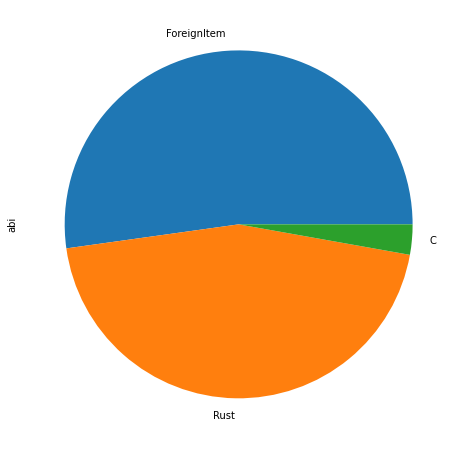

In [18]:
# Frequency of abi DEFINITIONS - top 250
values = unsafe_function_definitions_250.abi.value_counts()
print(values)
print(values / len(unsafe_function_definitions_250) * 100)
print("Unsafe function definitions:", len(unsafe_function_definitions_250))
values.plot.pie()
del values

Rust           1160
ForeignItem     907
C                78
Name: abi, dtype: int64
Rust           54.079254
ForeignItem    42.284382
C               3.636364
Name: abi, dtype: float64
Unsafe function definitions: 2145


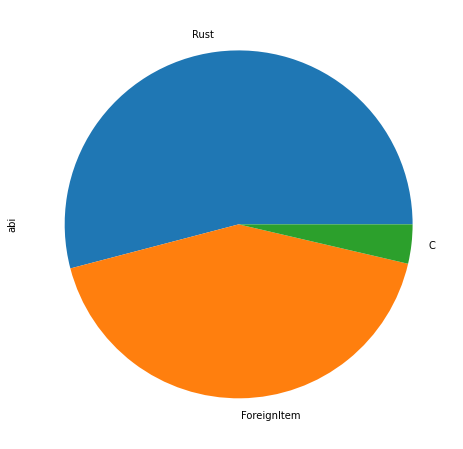

In [19]:
# Frequency of abi DEFINITIONS - top 500
values = unsafe_function_definitions_500.abi.value_counts()
print(values)
print(values / len(unsafe_function_definitions_500) * 100)
print("Unsafe function definitions:", len(unsafe_function_definitions_500))
values.plot.pie()
del values

Rust           1161
ForeignItem     907
C                78
Name: abi, dtype: int64
Rust           54.100652
ForeignItem    42.264678
C               3.634669
Name: abi, dtype: float64
Unsafe function definitions: 2146


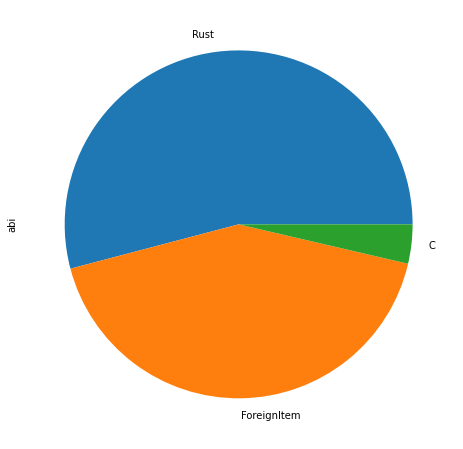

In [20]:
# Frequency of abi DEFINITIONS - top 1000
values = unsafe_function_definitions_1000.abi.value_counts()
print(values)
print(values / len(unsafe_function_definitions_1000) * 100)
print("Unsafe function definitions:", len(unsafe_function_definitions_1000))
values.plot.pie()
del values

ForeignItem    3478
Rust           2699
C               176
Name: abi, dtype: int64
ForeignItem    54.745789
Rust           42.483866
C               2.770345
Name: abi, dtype: float64
Unsafe function definitions: 6353


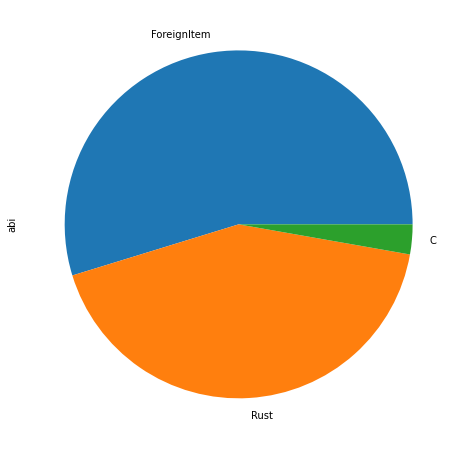

In [21]:
# Frequency of abi DEFINITIONS - ALL
values = unsafe_function_definitions.abi.value_counts()
print(values)
print(values / len(unsafe_function_definitions) * 100)
print("Unsafe function definitions:", len(unsafe_function_definitions))
values.plot.pie()
del values

In [22]:
# Which crates define unsafe Rust functions? - top 250
def_unsafe_rust_funcs_250 = unsafe_function_definitions_250[
    unsafe_function_definitions_250.abi == "Rust"
]

values = def_unsafe_rust_funcs_250.crate.value_counts()

print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values

Number of crates that define unsafe Rust functions:	 54
Names and counts of 20 crates with most defined unsafe Rust functions:

tokio               84
openssl             80
nix                 79
cloudabi            66
wasi                45
hashbrown           34
bytes               33
parking_lot         27
memchr              26
hyper               25
lock_api            23
parking_lot_core    21
encoding_rs         20
rand_chacha         18
dtoa                14
anyhow              11
httparse            11
ryu                  9
backtrace            9
smallvec             9
Name: crate, dtype: int64


In [23]:
# Which crates define unsafe Rust functions? - top 500
def_unsafe_rust_funcs_500 = unsafe_function_definitions_500[
    unsafe_function_definitions_500.abi == "Rust"
]

values = def_unsafe_rust_funcs_500.crate.value_counts()

print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values

Number of crates that define unsafe Rust functions:	 88
Names and counts of 20 crates with most defined unsafe Rust functions:

git2                108
tokio                84
openssl              80
nix                  79
blake2b_simd         77
cloudabi             66
wasi                 45
tendril              40
widestring           38
hashbrown            34
bytes                33
ascii                33
parking_lot          27
memchr               26
hyper                25
lock_api             23
parking_lot_core     21
encoding_rs          20
rand_chacha          18
bumpalo              16
Name: crate, dtype: int64


In [24]:
# Which crates define unsafe Rust functions? - top 1000
def_unsafe_rust_funcs_1000 = unsafe_function_definitions_1000[
    unsafe_function_definitions_1000.abi == "Rust"
]

values = def_unsafe_rust_funcs_1000.crate.value_counts()

print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values

Number of crates that define unsafe Rust functions:	 89
Names and counts of 20 crates with most defined unsafe Rust functions:

git2                108
tokio                84
openssl              80
nix                  79
blake2b_simd         77
cloudabi             66
wasi                 45
tendril              40
widestring           38
hashbrown            34
ascii                33
bytes                33
parking_lot          27
memchr               26
hyper                25
lock_api             23
parking_lot_core     21
encoding_rs          20
rand_chacha          18
bumpalo              16
Name: crate, dtype: int64


In [25]:
# Which crates define unsafe Rust functions? - ALL
def_unsafe_rust_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "Rust"
]

values = def_unsafe_rust_funcs.crate.value_counts()

print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values

Number of crates that define unsafe Rust functions:	 146
Names and counts of 20 crates with most defined unsafe Rust functions:

js_sys             803
futures_util       121
git2               108
tokio               84
openssl             80
nix                 79
blake2b_simd        77
wasm_bindgen        70
cloudabi            66
core_foundation     58
wasi                45
openssl_sys         42
aho_corasick        41
tendril             40
hermit_abi          39
widestring          38
hashbrown           34
bytes               33
ascii               33
rayon_core          33
Name: crate, dtype: int64


In [26]:
# Which crates define C functions? - top 250
def_c_funcs_250 = unsafe_function_definitions_250[
    unsafe_function_definitions_250.abi == "C"
]

values = def_c_funcs_250.crate.value_counts()

print("Number of crates that define C functions:\t", len(values))
print("Names and counts:")
print()
print(values)
del values

Number of crates that define C functions:	 4
Names and counts:

libc         27
openssl      18
ring          1
backtrace     1
Name: crate, dtype: int64


In [27]:
# Which crates define C functions? - top 500
def_c_funcs_500 = unsafe_function_definitions_500[
    unsafe_function_definitions_500.abi == "C"
]

values = def_c_funcs_500.crate.value_counts()

print("Number of crates that define C functions:\t", len(values))
print("Names and counts:")
print()
print(values)
del values

Number of crates that define C functions:	 5
Names and counts:

miniz_oxide_c_api    31
libc                 27
openssl              18
ring                  1
backtrace             1
Name: crate, dtype: int64


In [28]:
# Which crates define C functions? - top 1000
def_c_funcs_1000 = unsafe_function_definitions_1000[
    unsafe_function_definitions_1000.abi == "C"
]

values = def_c_funcs_1000.crate.value_counts()

print("Number of crates that define C functions:\t", len(values))
print("Names and counts:")
print()
print(values)
del values

Number of crates that define C functions:	 5
Names and counts:

miniz_oxide_c_api    31
libc                 27
openssl              18
ring                  1
backtrace             1
Name: crate, dtype: int64


In [29]:
# Which crates define C functions? - ALL
def_c_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "C"
]

values = def_c_funcs.crate.value_counts()

print("Number of crates that define C functions:\t", len(values))
print("Names and counts:")
print()
print(values)
del values

Number of crates that define C functions:	 7
Names and counts:

wasm_bindgen          96
miniz_oxide_c_api     31
libc                  27
openssl               18
security_framework     2
ring                   1
backtrace              1
Name: crate, dtype: int64


In [30]:
# Which crates define Foreign Items? - top 250
def_fi_funcs_250 = unsafe_function_definitions_250[
    unsafe_function_definitions_250.abi == "ForeignItem"
]

values = def_fi_funcs_250.crate.value_counts()

print("Number of crates that define Foreign Items:\t", len(values))
print("Names and counts of 20 crates with most defined Foreign Items:")
print()
print(values[:20])
del values

Number of crates that define Foreign Items:	 6
Names and counts of 20 crates with most defined Foreign Items:

libc         702
ring          74
cloudabi      49
wasi          45
backtrace      4
time           1
Name: crate, dtype: int64


In [31]:
# Which crates define Foreign Items? - top 500
def_fi_funcs_500 = unsafe_function_definitions_500[
    unsafe_function_definitions_500.abi == "ForeignItem"
]

values = def_fi_funcs_500.crate.value_counts()

print("Number of crates that define Foreign Items:\t", len(values))
print("Names and counts of 20 crates with most defined Foreign Items:")
print()
print(values[:20])
del values

Number of crates that define Foreign Items:	 12
Names and counts of 20 crates with most defined Foreign Items:

libc          702
ring           74
cloudabi       49
wasi           45
termios        13
xattr           8
libloading      5
backtrace       4
termion         3
errno           2
term_size       1
time            1
Name: crate, dtype: int64


In [32]:
# Which crates define Foreign Items? - top 1000
def_fi_funcs_1000 = unsafe_function_definitions_1000[
    unsafe_function_definitions_1000.abi == "ForeignItem"
]

values = def_fi_funcs_1000.crate.value_counts()

print("Number of crates that define Foreign Items:\t", len(values))
print("Names and counts of 20 crates with most defined Foreign Items:")
print()
print(values[:20])
del values

Number of crates that define Foreign Items:	 12
Names and counts of 20 crates with most defined Foreign Items:

libc          702
ring           74
cloudabi       49
wasi           45
termios        13
xattr           8
libloading      5
backtrace       4
termion         3
errno           2
term_size       1
time            1
Name: crate, dtype: int64


In [33]:
# Which crates define Foreign Items? - ALL
def_fi_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "ForeignItem"
]

values = def_fi_funcs.crate.value_counts()

print("Number of crates that define Foreign Items:\t", len(values))
print("Names and counts of 20 crates with most defined Foreign Items:")
print()
print(values[:20])
del values

Number of crates that define Foreign Items:	 31
Names and counts of 20 crates with most defined Foreign Items:

openssl_sys               733
libc                      702
libgit2_sys               593
clang_sys                 288
core_foundation_sys       230
libsqlite3_sys            174
fuchsia_zircon_sys        139
libssh2_sys                96
ring                       74
security_framework_sys     57
libz_sys                   56
hermit_abi                 55
lzma_sys                   52
cloudabi                   49
wasi                       45
curl_sys                   44
brotli_sys                 23
termios                    13
crypto                      9
xattr                       8
Name: crate, dtype: int64


Rust    796
C       561
Name: abi, dtype: int64
Rust    58.658806
C       41.341194
Name: abi, dtype: float64
Unsafe calls: 1357


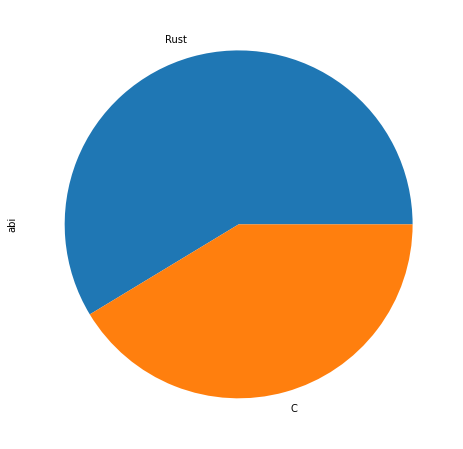

In [34]:
# Frequency of abi CALLS - top 250
unsafe_const_calls_250 = const_calls_250[
    const_calls_250.unsafety == "Unsafe"
]
values = unsafe_const_calls_250.abi.value_counts()
print(values)
print(values / len(unsafe_const_calls_250) * 100)
print("Unsafe calls:", len(unsafe_const_calls_250))
values.plot.pie()
del values

Rust    1545
C        587
Name: abi, dtype: int64
Rust    72.467167
C       27.532833
Name: abi, dtype: float64
Unsafe calls: 2132


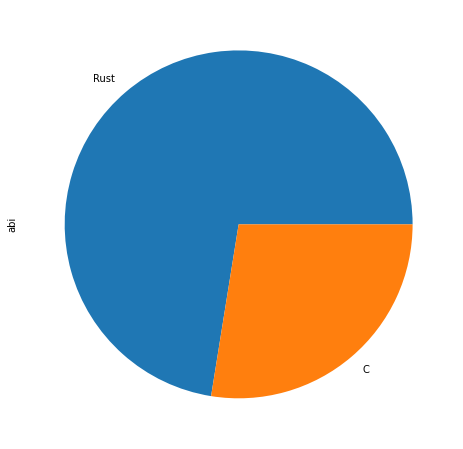

In [35]:
# Frequency of abi CALLS - top 500
unsafe_const_calls_500 = const_calls_500[
    const_calls_500.unsafety == "Unsafe"
]
values = unsafe_const_calls_500.abi.value_counts()
print(values)
print(values / len(unsafe_const_calls_500) * 100)
print("Unsafe calls:", len(unsafe_const_calls_500))
values.plot.pie()
del values

Rust    1546
C        587
Name: abi, dtype: int64
Rust    72.480075
C       27.519925
Name: abi, dtype: float64
Unsafe calls: 2133


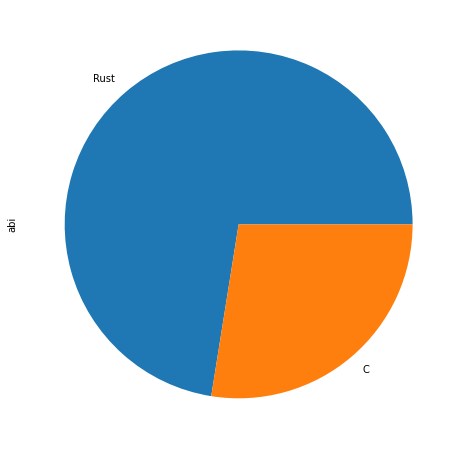

In [36]:
# Frequency of abi CALLS - top 1000
unsafe_const_calls_1000 = const_calls_1000[
    const_calls_1000.unsafety == "Unsafe"
]
values = unsafe_const_calls_1000.abi.value_counts()
print(values)
print(values / len(unsafe_const_calls_1000) * 100)
print("Unsafe calls:", len(unsafe_const_calls_1000))
values.plot.pie()
del values

Rust              7844
C                 2242
rust-intrinsic     644
Name: abi, dtype: int64
Rust              73.103448
C                 20.894688
rust-intrinsic     6.001864
Name: abi, dtype: float64
Unsafe calls: 10730


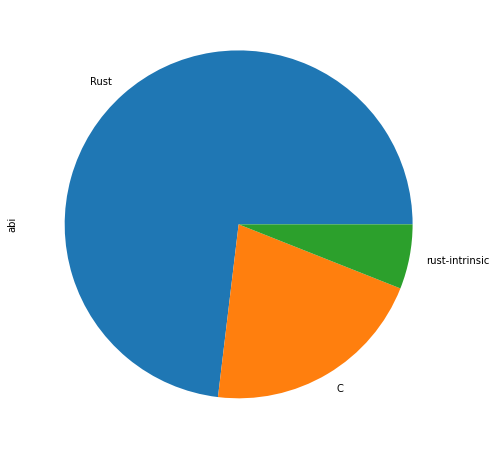

In [37]:
# Frequency of abi CALLS - ALL
unsafe_const_calls = const_calls[
    const_calls.unsafety == "Unsafe"
]
values = unsafe_const_calls.abi.value_counts()
print(values)
print(values / len(unsafe_const_calls) * 100)
print("Unsafe calls:", len(unsafe_const_calls))
values.plot.pie()
del values

In [38]:
# Which crates call unsafe Rust functions? - top 250
calls_unsafe_rust_funcs_250 = unsafe_const_calls_250[
    unsafe_const_calls_250.abi == "Rust"
]

values = calls_unsafe_rust_funcs_250.crate_defsite.value_counts()

print("Number of crates that call unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most unsafe Rust function calls:")
print()
print(values[:20])
del values

# Filter by user-written blocks
uw_calls_unsafe_rust_funcs_250 = calls_unsafe_rust_funcs_250[
    calls_unsafe_rust_funcs_250.check_mode == "UnsafeBlockUserProvided"
]

values = uw_calls_unsafe_rust_funcs_250.crate_defsite.value_counts()

print("Number of crates that call unsafe Rust functions from user-written blocks:\t", len(values))
print("Names and counts of 20 crates with most user-written unsafe Rust function calls:")
print()
print(values[:20])
del values

Number of crates that call unsafe Rust functions:	 41
Names and counts of 20 crates with most unsafe Rust function calls:

hashbrown           144
nix                  90
lock_api             70
socket2              53
encoding_rs          48
tokio                46
bytes                40
parking_lot_core     31
arrayvec             26
openssl              24
smallvec             20
memchr               18
rand_chacha          18
httparse             18
bstr                 15
http                 14
thread_local         12
syn                  11
byteorder            11
regex                10
Name: crate_defsite, dtype: int64
Number of crates that call unsafe Rust functions from user-written blocks:	 41
Names and counts of 20 crates with most user-written unsafe Rust function calls:

hashbrown           144
nix                  90
lock_api             70
socket2              53
encoding_rs          48
tokio                46
bytes                40
parking_lot_core     31
arrayvec  

In [39]:
# Which crates call unsafe Rust functions? - top 500
calls_unsafe_rust_funcs_500 = unsafe_const_calls_500[
    unsafe_const_calls_500.abi == "Rust"
]

values = calls_unsafe_rust_funcs_500.crate_defsite.value_counts()

print("Number of crates that call unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most unsafe Rust function calls:")
print()
print(values[:20])
del values

# Filter by user-written blocks
uw_calls_unsafe_rust_funcs_500 = calls_unsafe_rust_funcs_500[
    calls_unsafe_rust_funcs_500.check_mode == "UnsafeBlockUserProvided"
]

values = uw_calls_unsafe_rust_funcs_500.crate_defsite.value_counts()

print("Number of crates that call unsafe Rust functions from user-written blocks:\t", len(values))
print("Names and counts of 20 crates with most user-written unsafe Rust function calls:")
print()
print(values[:20])
del values

Number of crates that call unsafe Rust functions:	 66
Names and counts of 20 crates with most unsafe Rust function calls:

git2                318
combine             210
hashbrown           144
nix                  90
lock_api             70
tendril              56
socket2              53
encoding_rs          48
tokio                46
bytes                40
parking_lot_core     31
arrayvec             26
openssl              24
curl                 23
smallvec             20
json                 19
httparse             18
rand_chacha          18
memchr               18
tar                  16
Name: crate_defsite, dtype: int64
Number of crates that call unsafe Rust functions from user-written blocks:	 66
Names and counts of 20 crates with most user-written unsafe Rust function calls:

git2                318
combine             210
hashbrown           144
nix                  90
lock_api             70
tendril              56
socket2              53
encoding_rs          48
tokio     

In [40]:
# Which crates call unsafe Rust functions? - 1000
calls_unsafe_rust_funcs_1000 = unsafe_const_calls_1000[
    unsafe_const_calls_1000.abi == "Rust"
]

values = calls_unsafe_rust_funcs_1000.crate_defsite.value_counts()

print("Number of crates that call unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most unsafe Rust function calls:")
print()
print(values[:20])
del values

# Filter by user-written blocks
uw_calls_unsafe_rust_funcs_1000 = calls_unsafe_rust_funcs_1000[
    calls_unsafe_rust_funcs_1000.check_mode == "UnsafeBlockUserProvided"
]

values = uw_calls_unsafe_rust_funcs_1000.crate_defsite.value_counts()

print("Number of crates that call unsafe Rust functions from user-written blocks:\t", len(values))
print("Names and counts of 20 crates with most user-written unsafe Rust function calls:")
print()
print(values[:20])
del values

Number of crates that call unsafe Rust functions:	 67
Names and counts of 20 crates with most unsafe Rust function calls:

git2                318
combine             210
hashbrown           144
nix                  90
lock_api             70
tendril              56
socket2              53
encoding_rs          48
tokio                46
bytes                40
parking_lot_core     31
arrayvec             26
openssl              24
curl                 23
smallvec             20
json                 19
rand_chacha          18
memchr               18
httparse             18
tar                  16
Name: crate_defsite, dtype: int64
Number of crates that call unsafe Rust functions from user-written blocks:	 67
Names and counts of 20 crates with most user-written unsafe Rust function calls:

git2                318
combine             210
hashbrown           144
nix                  90
lock_api             70
tendril              56
socket2              53
encoding_rs          48
tokio     

In [41]:
# Which crates call unsafe Rust functions? - ALL
calls_unsafe_rust_funcs = unsafe_const_calls[
    unsafe_const_calls.abi == "Rust"
]

values = calls_unsafe_rust_funcs.crate_defsite.value_counts()

print("Number of crates that call unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most unsafe Rust function calls:")
print()
print(values[:20])
del values

# Filter by user-written blocks
uw_calls_unsafe_rust_funcs = calls_unsafe_rust_funcs[
    calls_unsafe_rust_funcs.check_mode == "UnsafeBlockUserProvided"
]

values = uw_calls_unsafe_rust_funcs.crate_defsite.value_counts()

print("Number of crates that call unsafe Rust functions from user-written blocks:\t", len(values))
print("Names and counts of 20 crates with most user-written unsafe Rust function calls:")
print()
print(values[:20])
del values

Number of crates that call unsafe Rust functions:	 115
Names and counts of 20 crates with most unsafe Rust function calls:

core                    3695
js_sys                   691
wasm_bindgen             581
git2                     318
combine                  210
foreign_types_shared     207
alloc                    181
std                      158
generic_array            149
hashbrown                144
core_foundation          129
clang_sys                115
nix                       90
lock_api                  70
sized_chunks              62
crossbeam_epoch           58
tendril                   56
socket2                   53
encoding_rs               48
tokio                     46
Name: crate_defsite, dtype: int64
Number of crates that call unsafe Rust functions from user-written blocks:	 115
Names and counts of 20 crates with most user-written unsafe Rust function calls:

core                    3484
js_sys                   691
wasm_bindgen             581
git2         

In [42]:
# Which crates call C functions? - top 250
calls_c_funcs_250 = unsafe_const_calls_250[
    unsafe_const_calls_250.abi == "C"
]

values = calls_c_funcs_250.crate_defsite.value_counts()

print("Number of crates that call C functions:\t", len(values))
print("Names and counts of 20 crates with most C function calls:")
print()
print(values[:20])
del values

Number of crates that call C functions:	 4
Names and counts of 20 crates with most C function calls:

libc         504
ring          53
backtrace      3
time           1
Name: crate_defsite, dtype: int64


In [43]:
# Which crates call C functions? - top 500
calls_c_funcs_500 = unsafe_const_calls_500[
    unsafe_const_calls_500.abi == "C"
]

values = calls_c_funcs_500.crate_defsite.value_counts()

print("Number of crates that call C functions:\t", len(values))
print("Names and counts of 20 crates with most C function calls:")
print()
print(values[:20])
del values

Number of crates that call C functions:	 9
Names and counts of 20 crates with most C function calls:

libc          504
ring           53
termios        13
libloading      5
termion         3
errno           3
backtrace       3
xattr           2
time            1
Name: crate_defsite, dtype: int64


In [44]:
# Which crates call C functions? - top 1000
calls_c_funcs_1000 = unsafe_const_calls_1000[
    unsafe_const_calls_1000.abi == "C"
]

values = calls_c_funcs_1000.crate_defsite.value_counts()

print("Number of crates that call C functions:\t", len(values))
print("Names and counts of 20 crates with most C function calls:")
print()
print(values[:20])
del values

Number of crates that call C functions:	 9
Names and counts of 20 crates with most C function calls:

libc          504
ring           53
termios        13
libloading      5
termion         3
errno           3
backtrace       3
xattr           2
time            1
Name: crate_defsite, dtype: int64


In [45]:
# Which crates call C functions? - ALL
calls_c_funcs = unsafe_const_calls[
    unsafe_const_calls.abi == "C"
]

values = calls_c_funcs.crate_defsite.value_counts()

print("Number of crates that call C functions:\t", len(values))
print("Names and counts of 20 crates with most C function calls:")
print()
print(values[:20])
del values

Number of crates that call C functions:	 23
Names and counts of 20 crates with most C function calls:

openssl_sys               748
libgit2_sys               544
libc                      504
core_foundation_sys       170
security_framework_sys     66
ring                       53
curl_sys                   47
wasm_bindgen               28
brotli_sys                 16
lzma_sys                   15
termios                    13
crypto                     11
libloading                  5
bzip2_sys                   4
backtrace                   3
inotify_sys                 3
termion                     3
errno                       3
xattr                       2
fuchsia_cprng               1
Name: crate_defsite, dtype: int64


In [46]:
# SIMD const calls total - top 250
simd_functions_250 = set([
    x
    for x in const_calls_250.def_path.unique()
    if x.startswith('core[7bab]::core_arch')
])
simd_calls = const_calls_250[
    const_calls_250.def_path.isin(simd_functions_250)
]

print("Total number of SIMD calls:\t", len(simd_calls))

# Get names of unique SIMD-calling crates
simd_crates = simd_calls.crate_callsite.unique()

print("Number of crates that call SIMD functions:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
del simd_calls, simd_crates

Total number of SIMD calls:	 0
Number of crates that call SIMD functions:	 0
Crates that call SIMD functions:
[]


In [47]:
# SIMD const calls total - top 500
simd_functions_500 = set([
    x
    for x in const_calls_500.def_path.unique()
    if x.startswith('core[7bab]::core_arch')
])
simd_calls = const_calls_500[
    const_calls_500.def_path.isin(simd_functions_500)
]

print("Total number of SIMD calls:\t", len(simd_calls))

# Get names of unique SIMD-calling crates
simd_crates = simd_calls.crate_callsite.unique()

print("Number of crates that call SIMD functions:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
del simd_calls, simd_crates

Total number of SIMD calls:	 0
Number of crates that call SIMD functions:	 0
Crates that call SIMD functions:
[]


In [48]:
# SIMD const calls total - top 1000
simd_functions_1000 = set([
    x
    for x in const_calls_1000.def_path.unique()
    if x.startswith('core[7bab]::core_arch')
])
simd_calls = const_calls_1000[
    const_calls_1000.def_path.isin(simd_functions_1000)
]

print("Total number of SIMD calls:\t", len(simd_calls))

# Get names of unique SIMD-calling crates
simd_crates = simd_calls.crate_callsite.unique()

print("Number of crates that call SIMD functions:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
del simd_calls, simd_crates

Total number of SIMD calls:	 0
Number of crates that call SIMD functions:	 0
Crates that call SIMD functions:
[]


In [49]:
# SIMD const calls total
simd_functions = set([
    x
    for x in const_calls.def_path.unique()
    if x.startswith('core[7bab]::core_arch')
])
simd_calls = const_calls[
    const_calls.def_path.isin(simd_functions)
]

print("Total number of SIMD calls:\t", len(simd_calls))

# Get names of unique SIMD-calling crates
simd_crates = simd_calls.crate_callsite.unique()

print("Number of crates that call SIMD functions:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
del simd_calls, simd_crates

Total number of SIMD calls:	 391
Number of crates that call SIMD functions:	 7
Crates that call SIMD functions:
['bstr' 'hashbrown' 'ahash' 'ppv_lite86' 'sha2' 'sha1' 'rdrand']


In [50]:
# Count functions with assembly code, per crate
asm_fns = function_unsafe_reasons[function_unsafe_reasons["use of inline assembly"]]
print("Number of functions using inline assembly:\t", len(asm_fns))
if len(asm_fns) > 0:
    values = asm_fns[['crate_name', 'crate_hash']].apply(
        lambda row: (row['crate_name'], row['crate_hash']), axis=1
    ).squeeze().value_counts()
    print("Number of crates:", len(values))
    print()
    print('Percentage of functions with inline assembly among 10 top crates:', sum(values[:10])/len(asm_fns)*100)
    print("Such functions per crate:")
    print(values[:10])
    asm_fns
    del values

Number of functions using inline assembly:	 0


In [51]:
# Unchecked functions - top 250
print("unchecked_function_names_250:\t", len(unchecked_function_names_250))

const_unchecked_calls_250 = const_calls_250[
    const_calls_250.def_path.isin(unchecked_function_names_250)
]
unchecked_calls_250 = unsafe_block_const_calls_250[
    unsafe_block_const_calls_250.def_path.isin(unchecked_function_names_250)
]
assert(len(const_unchecked_calls_250) == len(unchecked_calls_250))

print("Calls to unchecked functions:\t", len(unchecked_calls_250))
#print("Percentage:\t\t\t", len(unchecked_calls_250)/len(unsafe_calls_250)*100)

# Top unchecked() calling code
values = unchecked_calls_250 [['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/250*100)
print(values[:5])

# Used in Sec. 6.2
print("Percentage of unsafe blocks with an unchecked function call:\t",
    len(unchecked_calls_250.unsafe_scope.unique())/len(unsafe_block_const_calls_250.unsafe_scope.unique())*100
)
del values

unchecked_function_names_250:	 109
Calls to unchecked functions:	 31
Number of crates:		 8
Percentage:			 3.2
(http, 6808a9d62e774206)         14
(arrayvec, 8c2a468fe9f17483)      6
(h2, 4779d0bf4289d5ab)            4
(once_cell, ed17a4b20f68f687)     2
(petgraph, f3c73edaadc63bec)      2
dtype: int64
Percentage of unsafe blocks with an unchecked function call:	 1.94601381042059


In [52]:
# Unchecked functions - top 500
print("unchecked_function_names_500:\t", len(unchecked_function_names_500))

const_unchecked_calls_500 = const_calls_500[
    const_calls_500.def_path.isin(unchecked_function_names_500)
]
unchecked_calls_500 = unsafe_block_const_calls_500[
    unsafe_block_const_calls_500.def_path.isin(unchecked_function_names_500)
]
assert(len(const_unchecked_calls_500) == len(unchecked_calls_500))

print("Calls to unchecked functions:\t", len(unchecked_calls_500))
#print("Percentage:\t\t\t", len(unchecked_calls)/len(unsafe_calls)*100)

# Top unchecked() calling code
values = unchecked_calls_500[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/500*100)
print(values[:5])

# Used in Sec. 6.2
print("Percentage of unsafe blocks with an unchecked function call:\t",
    len(unchecked_calls_500.unsafe_scope.unique())/len(unsafe_block_const_calls_500.unsafe_scope.unique())*100
)
del values

unchecked_function_names_500:	 216
Calls to unchecked functions:	 78
Number of crates:		 16
Percentage:			 3.2
(http, 6808a9d62e774206)          14
(json, 79b54c8356a47b67)          14
(pest, 90a091c6ae19edc6)           8
(criterion, 8abcfaebda0e558c)      7
(widestring, 6d114c62fcc76497)     6
dtype: int64
Percentage of unsafe blocks with an unchecked function call:	 2.9106029106029108


In [53]:
# Unchecked functions - top 1000
print("unchecked_function_names_1000:\t", len(unchecked_function_names_1000))

const_unchecked_calls_1000 = const_calls_1000[
    const_calls_1000.def_path.isin(unchecked_function_names_1000)
]
unchecked_calls_1000 = unsafe_block_const_calls_1000[
    unsafe_block_const_calls_1000.def_path.isin(unchecked_function_names_1000)
]
assert(len(const_unchecked_calls_1000) == len(unchecked_calls_1000))

print("Calls to unchecked functions:\t", len(unchecked_calls_1000))
#print("Percentage:\t\t\t", len(unchecked_calls)/len(unsafe_calls)*100)

# Top unchecked() calling code
values = unchecked_calls_1000[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/1000*100)
print(values[:5])

# Used in Sec. 6.2
print("Percentage of unsafe blocks with an unchecked function call:\t",
    len(unchecked_calls_1000.unsafe_scope.unique())/len(unsafe_block_const_calls_1000.unsafe_scope.unique())*100
)
del values

unchecked_function_names_1000:	 216
Calls to unchecked functions:	 78
Number of crates:		 16
Percentage:			 1.6
(http, 6808a9d62e774206)          14
(json, 79b54c8356a47b67)          14
(pest, 90a091c6ae19edc6)           8
(criterion, 8abcfaebda0e558c)      7
(widestring, 6d114c62fcc76497)     6
dtype: int64
Percentage of unsafe blocks with an unchecked function call:	 2.898550724637681


In [54]:
# Unchecked functions - ALL
print("unchecked_function_names:\t", len(unchecked_function_names))

const_unchecked_calls = const_calls[
    const_calls.def_path.isin(unchecked_function_names)
]
unchecked_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unchecked_function_names)
]
assert(len(const_unchecked_calls) == len(unchecked_calls))

print("Calls to unchecked functions:\t", len(unchecked_calls))
print("Percentage:\t\t\t", len(unchecked_calls)/len(unsafe_calls)*100)

# Top unchecked() calling code
values = unchecked_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(selected_builds)*100)
print(values[:5])

# Used in Sec. 6.2
print("Percentage of unsafe blocks with an unchecked function call:\t",
    len(unchecked_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
)
del values

unchecked_function_names:	 366
Calls to unchecked functions:	 93
Percentage:			 0.0967812431706784
Number of crates:		 23
Percentage:			 4.509803921568627
(json, 79b54c8356a47b67)          14
(http, 6808a9d62e774206)          14
(pest, 90a091c6ae19edc6)           8
(criterion, 8abcfaebda0e558c)      7
(widestring, 6d114c62fcc76497)     6
dtype: int64
Percentage of unsafe blocks with an unchecked function call:	 0.7737119970872018


In [55]:
# Top called unchecked() code - 250
values = unchecked_calls_250[['def_path']].apply(
    lambda row: (row['def_path']), axis=1
).squeeze().value_counts()
print("Number of crates:\t", len(values))
print("Percentage:", len(values)/250*100)
print(values[:5])
del values

Number of crates:	 9
Percentage: 3.5999999999999996
http[4a33]::byte_str[0]::{{impl}}[0]::from_utf8_unchecked[0]          14
arrayvec[b80e]::{{impl}}[1]::get_unchecked_ptr[0]                      5
h2[c34a]::hpack[0]::header[0]::{{impl}}[4]::from_utf8_unchecked[0]     4
petgraph[aef9]::unionfind[0]::get_unchecked[0]                         2
once_cell[1308]::sync[0]::{{impl}}[6]::get_unchecked[0]                2
dtype: int64


In [56]:
# Top called unchecked() code - 500
values = unchecked_calls_500[['def_path']].apply(
    lambda row: (row['def_path']), axis=1
).squeeze().value_counts()
print("Number of crates:\t", len(values))
print("Percentage:", len(values)/500*100)
print(values[:5])
del values

Number of crates:	 23
Percentage: 4.6
json[ceec]::number[0]::{{impl}}[0]::from_parts_unchecked[0]                               14
http[4a33]::byte_str[0]::{{impl}}[0]::from_utf8_unchecked[0]                              14
criterion[738c]::stats[0]::univariate[0]::percentiles[0]::{{impl}}[0]::at_unchecked[0]     7
pest[3260]::position[0]::{{impl}}[0]::new_unchecked[0]                                     6
bytecount[4446]::integer_simd[0]::usize_load_unchecked[0]                                  6
dtype: int64


In [57]:
# Top called unchecked() code - 1000
values = unchecked_calls_1000[['def_path']].apply(
    lambda row: (row['def_path']), axis=1
).squeeze().value_counts()
print("Number of crates:\t", len(values))
print("Percentage:", len(values)/1000*100)
print(values[:5])
del values

Number of crates:	 23
Percentage: 2.3
json[ceec]::number[0]::{{impl}}[0]::from_parts_unchecked[0]                               14
http[4a33]::byte_str[0]::{{impl}}[0]::from_utf8_unchecked[0]                              14
criterion[738c]::stats[0]::univariate[0]::percentiles[0]::{{impl}}[0]::at_unchecked[0]     7
pest[3260]::position[0]::{{impl}}[0]::new_unchecked[0]                                     6
bytecount[4446]::integer_simd[0]::usize_load_unchecked[0]                                  6
dtype: int64


In [58]:
# Top called unchecked() code - ALL
values = unchecked_calls[['def_path']].apply(
    lambda row: (row['def_path']), axis=1
).squeeze().value_counts()
print("Number of crates:\t", len(values))
print("Percentage:", len(values)/len(selected_builds)*100)
print(values[:5])
del values

Number of crates:	 32
Percentage: 6.2745098039215685
http[4a33]::byte_str[0]::{{impl}}[0]::from_utf8_unchecked[0]                              14
json[ceec]::number[0]::{{impl}}[0]::from_parts_unchecked[0]                               14
criterion[738c]::stats[0]::univariate[0]::percentiles[0]::{{impl}}[0]::at_unchecked[0]     7
pest[3260]::position[0]::{{impl}}[0]::new_unchecked[0]                                     6
bytecount[4446]::integer_simd[0]::usize_load_unchecked[0]                                  6
dtype: int64


In [59]:
# Unguarded functions
print("unguarded_function_names:\t", len(unguarded_function_names))

const_unguarded_calls = const_calls[
    const_calls.def_path.isin(unguarded_function_names)
]
unguarded_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unguarded_function_names)
]
assert(len(const_unguarded_calls) == len(unguarded_calls))

print("Calls to unguarded functions:\t", len(unguarded_calls))
print("Percentage:\t\t\t", len(unguarded_calls)/len(unsafe_calls)*100)

values = unguarded_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(selected_builds)*100)
print(values[:5])

print("Percentage of unsafe blocks with an unguarded function call:\t",
     len(unguarded_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
)
del values

unguarded_function_names:	 0
Calls to unguarded functions:	 0
Percentage:			 0.0
Number of crates:		 0
Percentage:			 0.0
Series([], dtype: int64)
Percentage of unsafe blocks with an unguarded function call:	 0.0


In [60]:
### Filter by user-written unsafe code - 250
user_written_unsafe_const_calls_250 = const_calls_250[
    const_calls_250.check_mode == "UnsafeBlockUserProvided"
]

# Filter by target language
user_written_unsafe_const_calls_rust_250 = user_written_unsafe_const_calls_250[
    user_written_unsafe_const_calls_250.abi == "Rust"
]
user_written_unsafe_const_calls_fi_250 = user_written_unsafe_const_calls_250[
    user_written_unsafe_const_calls_250.abi == "ForeignItem"
]
user_written_unsafe_const_calls_c_250 = user_written_unsafe_const_calls_250[
    user_written_unsafe_const_calls_250.abi == "C"
]

# Filter for perf-mot functions within Rust
perf_mot_unsafe_rust_250 = set([
    x
    for x in user_written_unsafe_const_calls_rust_250.def_path.unique()
    if x.startswith('core[7bab]::core_arch') 
        or x.startswith('core[7bab]::intrinsics[0]::[1]::transmute[0]')
        or x.startswith('core[7bab]::intrinsics[0]::write_bytes[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy_nonoverlapping[0]')
        or x.startswith('core[7bab]::mem[0]::transmute_copy[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts_mut[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_ptr[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_mut_ptr[0]')
        or ("unchecked" in x)
        or ("unguarded" in x)
        or ("asm!" in x) # FIXME
])

In [61]:
### Filter by user-written unsafe code - 500
user_written_unsafe_const_calls_500 = const_calls_500[
    const_calls_500.check_mode == "UnsafeBlockUserProvided"
]

# Filter by target language
user_written_unsafe_const_calls_rust_500 = user_written_unsafe_const_calls_500[
    user_written_unsafe_const_calls_500.abi == "Rust"
]
user_written_unsafe_const_calls_fi_500 = user_written_unsafe_const_calls_500[
    user_written_unsafe_const_calls_500.abi == "ForeignItem"
]
user_written_unsafe_const_calls_c_500 = user_written_unsafe_const_calls_500[
    user_written_unsafe_const_calls_500.abi == "C"
]

# Filter for perf-mot functions within Rust
perf_mot_unsafe_rust_500 = set([
    x
    for x in user_written_unsafe_const_calls_rust_500.def_path.unique()
    if x.startswith('core[7bab]::core_arch') 
        or x.startswith('core[7bab]::intrinsics[0]::[1]::transmute[0]')
        or x.startswith('core[7bab]::intrinsics[0]::write_bytes[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy_nonoverlapping[0]')
        or x.startswith('core[7bab]::mem[0]::transmute_copy[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts_mut[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_ptr[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_mut_ptr[0]')
        or ("unchecked" in x)
        or ("unguarded" in x)
        or ("asm!" in x) # FIXME
])

In [62]:
### Filter by user-written unsafe code
user_written_unsafe_const_calls = const_calls[
    const_calls.check_mode == "UnsafeBlockUserProvided"
]

# Filter by target language
user_written_unsafe_const_calls_rust = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "Rust"
]
user_written_unsafe_const_calls_fi = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "ForeignItem"
]
user_written_unsafe_const_calls_c = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "C"
]

# Filter for perf-mot functions within Rust
perf_mot_unsafe_rust = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if x.startswith('core[7bab]::core_arch') 
        or x.startswith('core[7bab]::intrinsics[0]::[1]::transmute[0]')
        or x.startswith('core[7bab]::intrinsics[0]::write_bytes[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy_nonoverlapping[0]')
        or x.startswith('core[7bab]::mem[0]::transmute_copy[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts_mut[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_ptr[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_mut_ptr[0]')
        or ("unchecked" in x)
        or ("unguarded" in x)
        or ("asm!" in x) # FIXME
])

In [63]:
### Filter by user-written unsafe code - 1000
user_written_unsafe_const_calls_1000 = const_calls_1000[
    const_calls_1000.check_mode == "UnsafeBlockUserProvided"
]

# Filter by target language
user_written_unsafe_const_calls_rust_1000 = user_written_unsafe_const_calls_1000[
    user_written_unsafe_const_calls_1000.abi == "Rust"
]
user_written_unsafe_const_calls_fi_1000 = user_written_unsafe_const_calls_1000[
    user_written_unsafe_const_calls_1000.abi == "ForeignItem"
]
user_written_unsafe_const_calls_c_1000 = user_written_unsafe_const_calls_1000[
    user_written_unsafe_const_calls_1000.abi == "C"
]

# Filter for perf-mot functions within Rust
perf_mot_unsafe_rust_1000 = set([
    x
    for x in user_written_unsafe_const_calls_rust_1000.def_path.unique()
    if x.startswith('core[7bab]::core_arch') 
        or x.startswith('core[7bab]::intrinsics[0]::[1]::transmute[0]')
        or x.startswith('core[7bab]::intrinsics[0]::write_bytes[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy_nonoverlapping[0]')
        or x.startswith('core[7bab]::mem[0]::transmute_copy[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts_mut[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_ptr[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_mut_ptr[0]')
        or ("unchecked" in x)
        or ("unguarded" in x)
        or ("asm!" in x) # FIXME
])

In [64]:
# Performance-motivated Rust calls
# 250
perf_mot_unsafe_rust_calls_250 = user_written_unsafe_const_calls_rust_250[
    user_written_unsafe_const_calls_rust_250.def_path.isin(perf_mot_unsafe_rust_250)
]
pmu_rust_calls_250 = perf_mot_unsafe_rust_calls_250[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
# 500
perf_mot_unsafe_rust_calls_500 = user_written_unsafe_const_calls_rust_500[
    user_written_unsafe_const_calls_rust_500.def_path.isin(perf_mot_unsafe_rust_500)
]
pmu_rust_calls_500 = perf_mot_unsafe_rust_calls_500[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
# 1000
perf_mot_unsafe_rust_calls_1000 = user_written_unsafe_const_calls_rust_1000[
    user_written_unsafe_const_calls_rust_1000.def_path.isin(perf_mot_unsafe_rust_1000)
]
pmu_rust_calls_1000 = perf_mot_unsafe_rust_calls_1000[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
# ALL
perf_mot_unsafe_rust_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(perf_mot_unsafe_rust)
]
pmu_rust_calls = perf_mot_unsafe_rust_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)

# ForeignItem calls
fi_calls_250 = user_written_unsafe_const_calls_fi_250[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
fi_calls_500 = user_written_unsafe_const_calls_fi_500[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
fi_calls_1000 = user_written_unsafe_const_calls_fi_1000[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
fi_calls = user_written_unsafe_const_calls_fi[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)

# C calls
c_calls_250 = user_written_unsafe_const_calls_c_250[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
c_calls_500 = user_written_unsafe_const_calls_c_500[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
c_calls_1000 = user_written_unsafe_const_calls_c_1000[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
c_calls = user_written_unsafe_const_calls_c[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)

len_all = len(perf_mot_unsafe_rust_calls) + len(user_written_unsafe_const_calls_fi) + len(user_written_unsafe_const_calls_c)
len_all_250 = len(perf_mot_unsafe_rust_calls_250) + len(user_written_unsafe_const_calls_fi_250) + len(user_written_unsafe_const_calls_c_250)
len_all_500 = len(perf_mot_unsafe_rust_calls_500) + len(user_written_unsafe_const_calls_fi_500) + len(user_written_unsafe_const_calls_c_500)
len_all_1000 = len(perf_mot_unsafe_rust_calls_1000) + len(user_written_unsafe_const_calls_fi_1000) + len(user_written_unsafe_const_calls_c_1000)
#len_all_1000 = len(perf_mot_unsafe_rust_calls_1000) + len(user_written_unsafe_const_calls_fi_1000 + len(user_written_unsafe_const_calls_c_1000)

In [65]:
# 250
print("Total number of (user-written) PMU Rust calls:\t", len(perf_mot_unsafe_rust_calls_250))
print("Percent out of unsafe const calls:\t\t", len(perf_mot_unsafe_rust_calls_250)/len(user_written_unsafe_const_calls_250)*100)
print("Number of crates:\t", len(pmu_rust_calls_250.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls_250.value_counts())/250*100)
print()

print("Total number of ForeignItem calls:\t", len(user_written_unsafe_const_calls_fi_250))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_fi_250)/len(user_written_unsafe_const_calls_250)*100)
print("Number of crates:\t", len(fi_calls_250.value_counts()))
print("Percentage:\t\t", len(fi_calls_250.value_counts())/250*100)
print()

print("Total number of C calls:\t\t", len(user_written_unsafe_const_calls_c_250))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_c_250)/len(user_written_unsafe_const_calls_250)*100)
print("Number of crates:\t", len(c_calls_250.value_counts()))
print("Percentage:\t\t", len(c_calls_250.value_counts())/250*100)
print()

print("Total number of (user-written) PMU calls:\t\t", len_all_250)
print("Out of total number user-written unsafe const calls:\t", len(user_written_unsafe_const_calls_250))
print("Percent user-written PMU out of const calls:\t\t", len_all_250/len(user_written_unsafe_const_calls_250)*100)

block_frames = [pmu_rust_calls_250, fi_calls_250, c_calls_250]
block_values = pd.concat(block_frames)[0].value_counts()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/250*100)
del len_all_250, block_frames, block_values

Total number of (user-written) PMU Rust calls:	 45
Percent out of unsafe const calls:		 1.5734265734265735
Number of crates:	 10
Percentage:		 4.0

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 571
Percent out of unsafe const calls:	 19.965034965034963
Number of crates:	 34
Percentage:		 13.600000000000001

Total number of (user-written) PMU calls:		 616
Out of total number user-written unsafe const calls:	 2860
Percent user-written PMU out of const calls:		 21.53846153846154
Number of crates:	 44
Percentage:		 17.599999999999998


In [66]:
# 500
print("Total number of (user-written) PMU Rust calls:\t", len(perf_mot_unsafe_rust_calls_500))
print("Percent out of unsafe const calls:\t\t", len(perf_mot_unsafe_rust_calls_500)/len(user_written_unsafe_const_calls_500)*100)
print("Number of crates:\t", len(pmu_rust_calls_500.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls_500.value_counts())/500*100)
print()

print("Total number of ForeignItem calls:\t", len(user_written_unsafe_const_calls_fi_500))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_fi_500)/len(user_written_unsafe_const_calls_500)*100)
print("Number of crates:\t", len(fi_calls_500.value_counts()))
print("Percentage:\t\t", len(fi_calls_500.value_counts())/500*100)
print()

print("Total number of C calls:\t\t", len(user_written_unsafe_const_calls_c_500))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_c_500)/len(user_written_unsafe_const_calls_500)*100)
print("Number of crates:\t", len(c_calls_500.value_counts()))
print("Percentage:\t\t", len(c_calls_500.value_counts())/500*100)
print()

print("Total number of (user-written) PMU calls:\t\t", len_all_500)
print("Out of total number user-written unsafe const calls:\t", len(user_written_unsafe_const_calls_500))
print("Percent user-written PMU out of const calls:\t\t", len_all_500/len(user_written_unsafe_const_calls_500)*100)

block_frames = [pmu_rust_calls_500, fi_calls_500, c_calls_500]
block_values = pd.concat(block_frames)[0].value_counts()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/500*100)
del len_all_500, block_frames, block_values

Total number of (user-written) PMU Rust calls:	 101
Percent out of unsafe const calls:		 1.7362901839436136
Number of crates:	 18
Percentage:		 3.5999999999999996

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 597
Percent out of unsafe const calls:	 10.263022176379577
Number of crates:	 38
Percentage:		 7.6

Total number of (user-written) PMU calls:		 698
Out of total number user-written unsafe const calls:	 5817
Percent user-written PMU out of const calls:		 11.99931236032319
Number of crates:	 56
Percentage:		 11.200000000000001


In [67]:
# 1000
print("Total number of (user-written) PMU Rust calls:\t", len(perf_mot_unsafe_rust_calls_1000))
print("Percent out of unsafe const calls:\t\t", len(perf_mot_unsafe_rust_calls_1000)/len(user_written_unsafe_const_calls_1000)*100)
print("Number of crates:\t", len(pmu_rust_calls_1000.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls_1000.value_counts())/1000*100)
print()

print("Total number of ForeignItem calls:\t", len(user_written_unsafe_const_calls_fi_1000))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_fi_1000)/len(user_written_unsafe_const_calls_1000)*100)
print("Number of crates:\t", len(fi_calls_1000.value_counts()))
print("Percentage:\t\t", len(fi_calls_1000.value_counts())/1000*100)
print()

print("Total number of C calls:\t\t", len(user_written_unsafe_const_calls_c_1000))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_c_1000)/len(user_written_unsafe_const_calls_1000)*100)
print("Number of crates:\t", len(c_calls_1000.value_counts()))
print("Percentage:\t\t", len(c_calls_1000.value_counts())/1000*100)
print()

print("Total number of (user-written) PMU calls:\t\t", len_all_1000)
print("Out of total number user-written unsafe const calls:\t", len(user_written_unsafe_const_calls_1000))
print("Percent user-written PMU out of const calls:\t\t", len_all_1000/len(user_written_unsafe_const_calls_1000)*100)

block_frames = [pmu_rust_calls_1000, fi_calls_1000, c_calls_1000]
block_values = pd.concat(block_frames)[0].value_counts()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/1000*100)
del len_all_1000, block_frames, block_values

Total number of (user-written) PMU Rust calls:	 101
Percent out of unsafe const calls:		 1.7327157316863955
Number of crates:	 18
Percentage:		 1.7999999999999998

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 597
Percent out of unsafe const calls:	 10.241893978383942
Number of crates:	 38
Percentage:		 3.8

Total number of (user-written) PMU calls:		 698
Out of total number user-written unsafe const calls:	 5829
Percent user-written PMU out of const calls:		 11.97460971007034
Number of crates:	 56
Percentage:		 5.6000000000000005


In [68]:
# ALL
print("Total number of (user-written) PMU Rust calls:\t", len(perf_mot_unsafe_rust_calls))
print("Percent out of unsafe const calls:\t\t", len(perf_mot_unsafe_rust_calls)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(pmu_rust_calls.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls.value_counts())/len(selected_builds)*100)
print()

print("Total number of ForeignItem calls:\t", len(user_written_unsafe_const_calls_fi))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_fi)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(fi_calls.value_counts()))
print("Percentage:\t\t", len(fi_calls.value_counts())/len(selected_builds)*100)
print()

print("Total number of C calls:\t\t", len(user_written_unsafe_const_calls_c))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_c)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(c_calls.value_counts()))
print("Percentage:\t\t", len(c_calls.value_counts())/len(selected_builds)*100)
print()

print("Total number of (user-written) PMU calls:\t\t", len_all)
print("Out of total number user-written unsafe const calls:\t", len(user_written_unsafe_const_calls))
print("Percent user-written PMU out of const calls:\t\t", len_all/len(user_written_unsafe_const_calls)*100)

block_frames = [pmu_rust_calls, fi_calls, c_calls]
block_values = pd.concat(block_frames)[0].value_counts()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)
del len_all, block_frames, block_values

Total number of (user-written) PMU Rust calls:	 3394
Percent out of unsafe const calls:		 14.300160107862139
Number of crates:	 133
Percentage:		 26.078431372549023

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 2252
Percent out of unsafe const calls:	 9.488497514114771
Number of crates:	 51
Percentage:		 10.0

Total number of (user-written) PMU calls:		 5646
Out of total number user-written unsafe const calls:	 23734
Percent user-written PMU out of const calls:		 23.78865762197691
Number of crates:	 155
Percentage:		 30.392156862745097


In [69]:
# 250
len_all = len(def_c_funcs_250) + len(def_fi_funcs_250)

print("Total number of ForeignItem definitions:", len(def_fi_funcs_250))
print("Percent out of unsafe definitions:\t", len(def_fi_funcs_250)/len(unsafe_function_definitions_250)*100)
print("Number of crates:\t", len(def_fi_funcs_250.crate.value_counts()))
print("Percentage:\t\t", len(def_fi_funcs_250.crate.value_counts())/250*100)
print()

print("Total number of C definitions:\t\t", len(def_c_funcs_250))
print("Percent out of unsafe definitions:\t", len(def_c_funcs_250)/len(unsafe_function_definitions_250)*100)
print("Number of crates:\t", len(def_c_funcs_250.crate.value_counts()))
print("Percentage:\t\t", len(def_c_funcs_250.crate.value_counts())/250*100)
print()

print("Total number of PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(unsafe_function_definitions_250))
print("Percent PMU out of unsafe definitions:\t", len_all/len(unsafe_function_definitions_250)*100)

block_frames = [def_c_funcs_250, def_fi_funcs_250]
block_values = pd.concat(block_frames).crate.value_counts()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/250*100)
del len_all, block_frames, block_values

Total number of ForeignItem definitions: 875
Percent out of unsafe definitions:	 52.207637231503575
Number of crates:	 6
Percentage:		 2.4

Total number of C definitions:		 47
Percent out of unsafe definitions:	 2.8042959427207634
Number of crates:	 4
Percentage:		 1.6

Total number of PMU definitions:	 922
Total number of unsafe function defs:	 1676
Percent PMU out of unsafe definitions:	 55.011933174224346
Number of crates:	 7
Percentage:		 2.8000000000000003


In [70]:
# 500
len_all = len(def_c_funcs_500) + len(def_fi_funcs_500)

print("Total number of ForeignItem definitions:", len(def_fi_funcs_500))
print("Percent out of unsafe definitions:\t", len(def_fi_funcs_500)/len(unsafe_function_definitions_500)*100)
print("Number of crates:\t", len(def_fi_funcs_500.crate.value_counts()))
print("Percentage:\t\t", len(def_fi_funcs_500.crate.value_counts())/500*100)
print()

print("Total number of C definitions:\t\t", len(def_c_funcs_500))
print("Percent out of unsafe definitions:\t", len(def_c_funcs_500)/len(unsafe_function_definitions_500)*100)
print("Number of crates:\t", len(def_c_funcs_500.crate.value_counts()))
print("Percentage:\t\t", len(def_c_funcs_500.crate.value_counts())/500*100)
print()

print("Total number of PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(unsafe_function_definitions_500))
print("Percent PMU out of unsafe definitions:\t", len_all/len(unsafe_function_definitions_500)*100)

block_frames = [def_c_funcs_500, def_fi_funcs_500]
block_values = pd.concat(block_frames).crate.value_counts()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/500*100)
del len_all, block_frames, block_values

Total number of ForeignItem definitions: 907
Percent out of unsafe definitions:	 42.28438228438228
Number of crates:	 12
Percentage:		 2.4

Total number of C definitions:		 78
Percent out of unsafe definitions:	 3.6363636363636362
Number of crates:	 5
Percentage:		 1.0

Total number of PMU definitions:	 985
Total number of unsafe function defs:	 2145
Percent PMU out of unsafe definitions:	 45.92074592074592
Number of crates:	 14
Percentage:		 2.8000000000000003


In [71]:
# 1000
len_all = len(def_c_funcs_1000) + len(def_fi_funcs_1000)

print("Total number of ForeignItem definitions:", len(def_fi_funcs_1000))
print("Percent out of unsafe definitions:\t", len(def_fi_funcs_1000)/len(unsafe_function_definitions_1000)*100)
print("Number of crates:\t", len(def_fi_funcs_1000.crate.value_counts()))
print("Percentage:\t\t", len(def_fi_funcs_1000.crate.value_counts())/1000*100)
print()

print("Total number of C definitions:\t\t", len(def_c_funcs_1000))
print("Percent out of unsafe definitions:\t", len(def_c_funcs_1000)/len(unsafe_function_definitions_1000)*100)
print("Number of crates:\t", len(def_c_funcs_1000.crate.value_counts()))
print("Percentage:\t\t", len(def_c_funcs_1000.crate.value_counts())/1000*100)
print()

print("Total number of PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(unsafe_function_definitions_1000))
print("Percent PMU out of unsafe definitions:\t", len_all/len(unsafe_function_definitions_1000)*100)

block_frames = [def_c_funcs_1000, def_fi_funcs_1000]
block_values = pd.concat(block_frames).crate.value_counts()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/1000*100)
del len_all, block_frames, block_values

Total number of ForeignItem definitions: 907
Percent out of unsafe definitions:	 42.264678471575024
Number of crates:	 12
Percentage:		 1.2

Total number of C definitions:		 78
Percent out of unsafe definitions:	 3.6346691519105314
Number of crates:	 5
Percentage:		 0.5

Total number of PMU definitions:	 985
Total number of unsafe function defs:	 2146
Percent PMU out of unsafe definitions:	 45.89934762348555
Number of crates:	 14
Percentage:		 1.4000000000000001


In [72]:
# ALL
len_all = len(def_c_funcs) + len(def_fi_funcs)

print("Total number of ForeignItem definitions:", len(def_fi_funcs))
print("Percent out of unsafe definitions:\t", len(def_fi_funcs)/len(unsafe_function_definitions)*100)
print("Number of crates:\t", len(def_fi_funcs.crate.value_counts()))
print("Percentage:\t\t", len(def_fi_funcs.crate.value_counts())/len(selected_builds)*100)
print()

print("Total number of C definitions:\t\t", len(def_c_funcs))
print("Percent out of unsafe definitions:\t", len(def_c_funcs)/len(unsafe_function_definitions)*100)
print("Number of crates:\t", len(def_c_funcs.crate.value_counts()))
print("Percentage:\t\t", len(def_c_funcs.crate.value_counts())/len(selected_builds)*100)
print()

print("Total number of PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(unsafe_function_definitions))
print("Percent PMU out of unsafe definitions:\t", len_all/len(unsafe_function_definitions)*100)

block_frames = [def_c_funcs, def_fi_funcs]
block_values = pd.concat(block_frames).crate.value_counts()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)
del len_all, block_frames, block_values

Total number of ForeignItem definitions: 3478
Percent out of unsafe definitions:	 54.74578939083897
Number of crates:	 31
Percentage:		 6.078431372549019

Total number of C definitions:		 176
Percent out of unsafe definitions:	 2.7703447190303794
Number of crates:	 7
Percentage:		 1.3725490196078431

Total number of PMU definitions:	 3654
Total number of unsafe function defs:	 6353
Percent PMU out of unsafe definitions:	 57.516134109869355
Number of crates:	 35
Percentage:		 6.862745098039216


In [73]:
# Total PMU code - top 250
block_frames = [pmu_rust_calls_250, c_calls_250, fi_calls_250, def_c_funcs_250, def_fi_funcs_250] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/250*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values

Number of crates:	 44
Percentage:		 17.599999999999998

List of 20 crates with the most performance-motivated unsafe code:
(nix, 887ec1e304ae466c)                     361
(ring, 57d7c3f120e595e4)                     55
(socket2, 6869bbcc40c6bc36)                  24
(mio_uds, e228ae90eac32a2f)                  17
(http, 6808a9d62e774206)                     14
(net2, ba284078fdc84fc3)                     13
(thread_local, 34efe6da1e3a2913)             12
(signal_hook, 2b414ebdbbd10809)              10
(inotify, c46328d0c3387f4)                    9
(console, 2b9352d588c33c7a)                   9
(signal_hook_registry, b1e43c155a08b3f2)      8
(jobserver, 1654b3ded9fdd17e)                 6
(memmap, bb65f38020be9e9d)                    6
(arrayvec, 8c2a468fe9f17483)                  6
(filetime, cf26ac4be91f847a)                  5
(backtrace, 75be4f73c27229b0)                 5
(getrandom, 223655fb17bc169d)                 5
(h2, 4779d0bf4289d5ab)                        4
(fs2, f0009d4

In [74]:
# Total PMU code - top 500
block_frames = [pmu_rust_calls_500, c_calls_500, fi_calls_500, def_c_funcs_500, def_fi_funcs_500] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/500*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values

Number of crates:	 56
Percentage:		 11.200000000000001

List of 20 crates with the most performance-motivated unsafe code:
(nix, 887ec1e304ae466c)                     361
(ring, 57d7c3f120e595e4)                     55
(socket2, 6869bbcc40c6bc36)                  24
(mio_uds, e228ae90eac32a2f)                  17
(http, 6808a9d62e774206)                     14
(json, 79b54c8356a47b67)                     14
(termios, 13531b8948f1d924)                  13
(net2, ba284078fdc84fc3)                     13
(thread_local, 34efe6da1e3a2913)             12
(signal_hook, 2b414ebdbbd10809)              10
(console, 2b9352d588c33c7a)                   9
(inotify, c46328d0c3387f4)                    9
(signal_hook_registry, b1e43c155a08b3f2)      8
(pest, 90a091c6ae19edc6)                      8
(criterion, 8abcfaebda0e558c)                 7
(encode_unicode, 299827f135e2155b)            7
(ascii, a5f83482bb64d06b)                     7
(arrayvec, 8c2a468fe9f17483)                  6
(termion, cfc

In [75]:
# Total PMU code - top 1000
block_frames = [pmu_rust_calls_1000, c_calls_1000, fi_calls_1000, def_c_funcs_1000, def_fi_funcs_1000] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/1000*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values

Number of crates:	 56
Percentage:		 5.6000000000000005

List of 20 crates with the most performance-motivated unsafe code:
(nix, 887ec1e304ae466c)                     361
(ring, 57d7c3f120e595e4)                     55
(socket2, 6869bbcc40c6bc36)                  24
(mio_uds, e228ae90eac32a2f)                  17
(http, 6808a9d62e774206)                     14
(json, 79b54c8356a47b67)                     14
(termios, 13531b8948f1d924)                  13
(net2, ba284078fdc84fc3)                     13
(thread_local, 34efe6da1e3a2913)             12
(signal_hook, 2b414ebdbbd10809)              10
(console, 2b9352d588c33c7a)                   9
(inotify, c46328d0c3387f4)                    9
(signal_hook_registry, b1e43c155a08b3f2)      8
(pest, 90a091c6ae19edc6)                      8
(criterion, 8abcfaebda0e558c)                 7
(encode_unicode, 299827f135e2155b)            7
(ascii, a5f83482bb64d06b)                     7
(arrayvec, 8c2a468fe9f17483)                  6
(termion, cfc

In [76]:
# Total PMU code - ALL
block_frames = [pmu_rust_calls, c_calls, fi_calls, def_c_funcs, def_fi_funcs] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values

Number of crates:	 155
Percentage:		 30.392156862745097

List of 20 crates with the most performance-motivated unsafe code:
(openssl, e0a61a472766a940)               903
(git2, 1f7321677b9caa95)                  578
(futures_util, 12b18cbb38d82e85)          455
(nix, 887ec1e304ae466c)                   414
(ppv_lite86, 8f7f8b0411c06b17)            366
(lexical_core, e1470018361eb732)          258
(tokio, 8c26b051124c49b3)                 221
(actix_web, baf8718645b0d8b)              190
(encoding_rs, 31e96fc597d9d5fc)           178
(core_foundation, fd9e7bfc17ad8030)       170
(ring, 57d7c3f120e595e4)                  164
(byteorder, 6c647b065da2cdba)             142
(generic_array, de092b675d6ebae)           82
(security_framework, 870f742179095607)     81
(ahash, d6afb292932ea61a)                  77
(crypto, 44cdc7433e3acc7d)                 76
(hyper, 7113324d1b5fa109)                  71
(rand, 7ee2ef94785bad32)                   68
(rayon, adfcf1b0135a2616)                  63
(i

In [77]:
# Filter for perf-mot functions within Rust - 250
unchecked_250 = set([
    x
    for x in user_written_unsafe_const_calls_rust_250.def_path.unique()
    if ("get_unchecked" in x)
])

unchecked_calls_250 = user_written_unsafe_const_calls_rust_250[
    user_written_unsafe_const_calls_rust_250.def_path.isin(unchecked_250)
]
cleaned_unchecked_calls_250 = unchecked_calls_250[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls_250))
cleaned_unchecked_calls_250

Number of crates that use get_unchecked[_mut]:	 3


(arrayvec, 0.5.1)     5
(petgraph, 0.5.1)     2
(once_cell, 1.4.1)    2
dtype: int64

In [78]:
# Filter for perf-mot functions within Rust - 500
unchecked_500 = set([
    x
    for x in user_written_unsafe_const_calls_rust_500.def_path.unique()
    if ("get_unchecked" in x)
])

unchecked_calls_500 = user_written_unsafe_const_calls_rust_500[
    user_written_unsafe_const_calls_rust_500.def_path.isin(unchecked_500)
]
cleaned_unchecked_calls_500 = unchecked_calls_500[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls_500))
cleaned_unchecked_calls_500

Number of crates that use get_unchecked[_mut]:	 3


(arrayvec, 0.5.1)     5
(petgraph, 0.5.1)     2
(once_cell, 1.4.1)    2
dtype: int64

In [79]:
# Filter for perf-mot functions within Rust - 1000
unchecked_1000 = set([
    x
    for x in user_written_unsafe_const_calls_rust_1000.def_path.unique()
    if ("get_unchecked" in x)
])

unchecked_calls_1000 = user_written_unsafe_const_calls_rust_1000[
    user_written_unsafe_const_calls_rust_1000.def_path.isin(unchecked_1000)
]
cleaned_unchecked_calls_1000 = unchecked_calls_1000[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls_1000))
cleaned_unchecked_calls_1000

Number of crates that use get_unchecked[_mut]:	 3


(arrayvec, 0.5.1)     5
(petgraph, 0.5.1)     2
(once_cell, 1.4.1)    2
dtype: int64

In [80]:
# Filter for perf-mot functions within Rust
unchecked = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if ("get_unchecked" in x)
])

unchecked_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(unchecked)
]
cleaned_unchecked_calls = unchecked_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
cleaned_unchecked_calls

Number of crates that use get_unchecked[_mut]:	 38


(lexical_core, 0.7.4)         245
(futures_util, 0.3.6)         119
(encoding_rs, 0.8.24)         113
(tokio, 0.2.22)                68
(priority_queue, 1.0.2)        54
(actix_web, 3.1.0)             31
(rayon, 1.4.1)                 30
(crypto, 0.2.36)               24
(hyper, 0.13.8)                21
(combine, 4.3.2)               17
(rand_hc, 0.2.0)               16
(json, 0.12.4)                 12
(fixedbitset, 0.3.1)           10
(crossbeam_deque, 0.8.0)       10
(httparse, 1.3.4)               9
(tokio_util, 0.3.1)             6
(petgraph, 0.5.1)               5
(arrayvec, 0.5.1)               5
(futures_task, 0.3.6)           5
(reqwest, 0.10.8)               5
(ryu, 1.0.5)                    4
(siphasher, 0.3.3)              4
(crossbeam_queue, 0.3.0)        3
(sized_chunks, 0.6.2)           3
(bstr, 0.2.13)                  3
(rand_core, 0.5.1)              2
(futf, 0.1.4)                   2
(criterion, 0.3.3)              2
(generic_array, 0.14.4)         2
(tracing, 0.1.